In [1]:
import nzshm_utils
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import time
import os
os.chdir("/home/jovyan/notebooks/")
os.getcwd()

'/home/jovyan/notebooks'

In [2]:
# file_name= '../logs/inversionlogging_1024_gzip_100k/solution.parquet'
# column_name = 'solution'
# file_name= '../logs/inversionlogging_lz4_100k/solution.parquet'
# column_name = 'solution'
# file_name= '../logs/inversionlogging_100min_par/solution.parquet'
file_name= '../logs/inversionlogging_1bil/solution.parquet'
column_name = 'solution'

# file_name= '../logs/inversionlogging_1024_gzip_100k/misfits.parquet'
# column_name = 'misfits'

# print file metadata
parquet_file = pq.ParquetFile(file_name)
print(parquet_file.metadata)
print(parquet_file.schema)

  created_by: parquet-mr version 1.15.1 (build c7257b8faff5699e13bbc781679dc03f48c1102a)
  num_columns: 1
  num_rows: 1001
  num_row_groups: 11
  format_version: 1.0
  serialized_size: 2106
required group field_id=-1 solution {
  required group field_id=-1 solution (List) {
    repeated double field_id=-1 array;
  }
}



In [3]:
# groups with processses

def computation(previous, row):
  count = np.count_nonzero(row)
  previousNonZero = previous != 0
  nonZero = row != 0
  ids = np.logical_and(previousNonZero, nonZero)
  data_p = previous[ids]
  data_c = row[ids]
  data = (data_c - data_p)/data_p
  mean= np.mean(data)
  median = np.median(data)
  xor = np.logical_xor(previousNonZero, nonZero)
  added = np.count_nonzero(row[xor])
  removed = np.count_nonzero(previous[xor])
  return np.array([count, added, removed, mean, median])

start_time = time.time()     
result = nzshm_utils.parquet_iterator_parallel(file_name, column_name, computation, 5)
print(time.time() - start_time)


/opt/conda/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.8799006938934326


In [4]:
parquet_file = pq.ParquetFile('../logs/inversionlogging_1bil/meta.parquet')
print(parquet_file.metadata)
print(parquet_file.schema)

# Batch iterator. Slower than row groups
# def parquet_iterator(parquet_file, column):
#   for record_batch in parquet_file.iter_batches(batch_size=1000):
#       for row in record_batch.to_pandas()[column]:
#           yield row
          
def parquet_iterator(parquet_file, column):
  for index in range(parquet_file.metadata.num_row_groups):
      record_batch = parquet_file.read_row_group(index)
      for row in record_batch.to_pandas()[column]:
        yield row

  created_by: parquet-mr version 1.15.1 (build c7257b8faff5699e13bbc781679dc03f48c1102a)
  num_columns: 5
  num_rows: 1001
  num_row_groups: 11
  format_version: 1.0
  serialized_size: 7210
required group field_id=-1 meta {
  required int64 field_id=-1 iterations;
  required int64 field_id=-1 elapsedTimeMillis;
  required int64 field_id=-1 numPerturbsKept;
  required int64 field_id=-1 numWorseValuesKept;
  required int64 field_id=-1 numNonZero;
}



In [16]:
iterations = tuple(parquet_iterator(parquet_file, 'iterations'))
iterations

(0,
 1000000,
 2000000,
 3000000,
 4000000,
 5000000,
 6000000,
 7000000,
 8000000,
 9000000,
 10000000,
 11000000,
 12000000,
 13000000,
 14000000,
 15000000,
 16000000,
 17000000,
 18000000,
 19000000,
 20000000,
 21000000,
 22000000,
 23000000,
 24000000,
 25000000,
 26000000,
 27000000,
 28000000,
 29000000,
 30000000,
 31000000,
 32000000,
 33000000,
 34000000,
 35000000,
 36000000,
 37000000,
 38000000,
 39000000,
 40000000,
 41000000,
 42000000,
 43000000,
 44000000,
 45000000,
 46000000,
 47000000,
 48000000,
 49000000,
 50000000,
 51000000,
 52000000,
 53000000,
 54000000,
 55000000,
 56000000,
 57000000,
 58000000,
 59000000,
 60000000,
 61000000,
 62000000,
 63000000,
 64000000,
 65000000,
 66000000,
 67000000,
 68000000,
 69000000,
 70000000,
 71000000,
 72000000,
 73000000,
 74000000,
 75000000,
 76000000,
 77000000,
 78000000,
 79000000,
 80000000,
 81000000,
 82000000,
 83000000,
 84000000,
 85000000,
 86000000,
 87000000,
 88000000,
 89000000,
 90000000,
 91000000,
 920

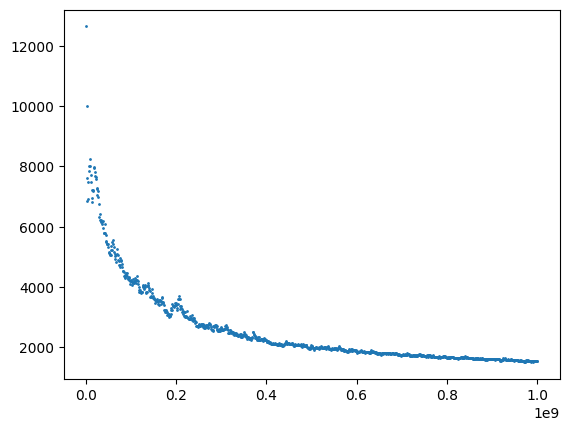

In [11]:
plt.scatter(np.array(iterations)[1:],result[0], s=1)



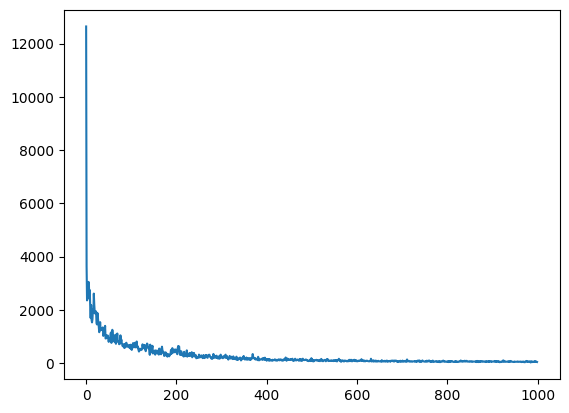

In [12]:
plt.plot(result[1])

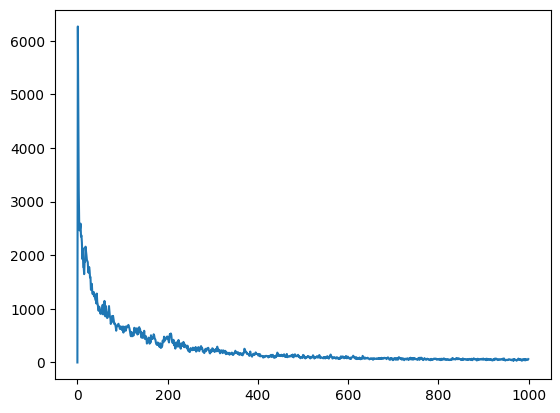

In [13]:
plt.plot(result[2])

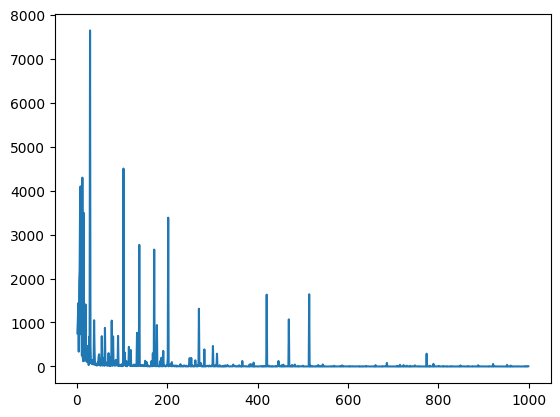

In [14]:
plt.plot(result[3])


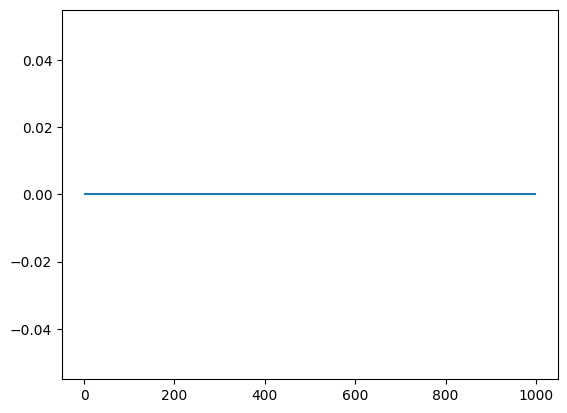

In [15]:
plt.plot(result[4])